In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
import wandb

from data import WordSequenceDataset
from model import EncoderOnlyNextTokenPredictor

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\\s]", "", text)  
    return text

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 100
learning_rate = 1e-3
window_size = 3
max_vocab_size = 50

In [17]:
dataset = WordSequenceDataset("data/simple_corpus2.txt", window_size=window_size, max_vocab_size=max_vocab_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[DEBUG] final samples : 15


In [ ]:
print("# of vocabs", dataset.vocab_size)
print("Top 20 vocabs:", list(dataset.token2idx.keys())[2:22])

총 vocab 개수: 42
상위 20개 단어: ['is', 'because', 'does', 'i', 'he', 'you', 'we', 'she', 'they', 'coffee', 'movie', 'game', 'work', 'pizza', 'school', 'music', 'chocolate', 'eat', 'home', 'book']


### Dataset & Dataloader

### Model setup

In [18]:
model = EncoderOnlyNextTokenPredictor(vocab_size=dataset.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Loop

In [19]:
wandb.init(project="embedding-visualization", config={
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
    "max_vocab_size": max_vocab_size
})

In [20]:
wandb.watch(model.token_embedding, log="all", log_freq=10)

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        grad_norm = torch.norm(model.token_embedding.embedding.weight.grad)
        wandb.log({"embedding_grad_norm": grad_norm.item()})

        embedding_weights = model.token_embedding.embedding.weight.detach().cpu().numpy()
        wandb.log({
            "embedding_weights_step": wandb.Histogram(embedding_weights.flatten())
        })

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    wandb.log({"loss": avg_loss, "epoch": epoch})


Epoch 1: Loss = 3.5267
Epoch 2: Loss = 3.1499
Epoch 3: Loss = 2.7888
Epoch 4: Loss = 2.5317
Epoch 5: Loss = 2.3229
Epoch 6: Loss = 2.1422
Epoch 7: Loss = 1.9999
Epoch 8: Loss = 1.8653
Epoch 9: Loss = 1.7830
Epoch 10: Loss = 1.6626
Epoch 11: Loss = 1.5449
Epoch 12: Loss = 1.4038
Epoch 13: Loss = 1.3118
Epoch 14: Loss = 1.1887
Epoch 15: Loss = 1.0928
Epoch 16: Loss = 1.0007
Epoch 17: Loss = 0.9286
Epoch 18: Loss = 0.8306
Epoch 19: Loss = 0.7857
Epoch 20: Loss = 0.7438
Epoch 21: Loss = 0.6709
Epoch 22: Loss = 0.6409
Epoch 23: Loss = 0.6042
Epoch 24: Loss = 0.5743
Epoch 25: Loss = 0.5374
Epoch 26: Loss = 0.5302
Epoch 27: Loss = 0.4990
Epoch 28: Loss = 0.4810
Epoch 29: Loss = 0.4626
Epoch 30: Loss = 0.4356
Epoch 31: Loss = 0.4305
Epoch 32: Loss = 0.3961
Epoch 33: Loss = 0.3898
Epoch 34: Loss = 0.4019
Epoch 35: Loss = 0.3734
Epoch 36: Loss = 0.3775
Epoch 37: Loss = 0.3618
Epoch 38: Loss = 0.3543
Epoch 39: Loss = 0.3409
Epoch 40: Loss = 0.3265
Epoch 41: Loss = 0.3247
Epoch 42: Loss = 0.3136
E

### Non-contextual visualization

In [21]:
def visualize_token_embeddings(model, idx2token):
    emb = model.token_embedding.embedding.weight.detach().cpu().numpy()
    reduced = TSNE(n_components=2, perplexity=5).fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for i, label in idx2token.items():
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=12)
    plt.title("Non-Contextual Token Embedding")
    plt.grid(True)
    plt.show()

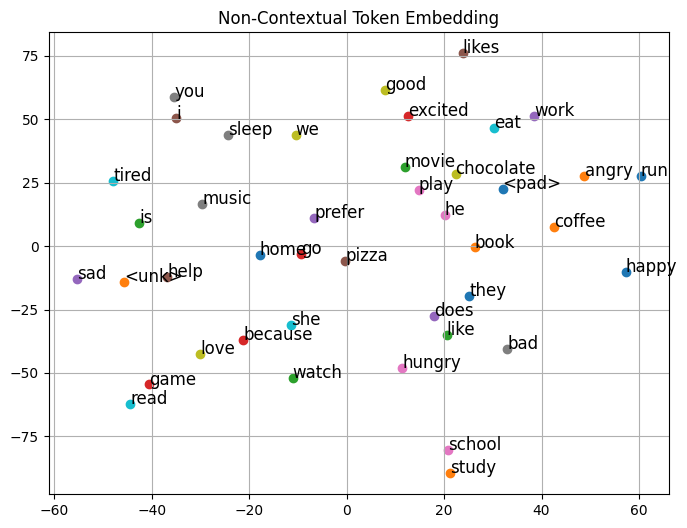

In [14]:
visualize_token_embeddings(model, dataset.idx2token)

### Contextual Embedding

In [24]:
def extract_contextual_embeddings(model, sentence, token2idx):
    model.eval()
    tokens = sentence.split()
    idxs = [token2idx.get(tok, 1) for tok in tokens]  # 1 is <unk>
    x = torch.tensor([idxs]).to(device)

    with torch.no_grad():
        tok_emb = model.token_embedding(x)
        pos_emb = model.pos_embedding(x)
        x = tok_emb + pos_emb
        for layer in model.encoder_layers:
            x = layer(x)
        x = model.norm(x)
        return x.squeeze(0).cpu().numpy(), tokens

def visualize_contextual_embeddings(model, token2idx, sentences):
    vectors = []
    labels = []
    for sentence in sentences:
        vecs, toks = extract_contextual_embeddings(model, sentence, token2idx)
        vectors.extend(vecs)
        labels.extend([f"{tok} ({sentence})" for tok in toks])

    reduced = TSNE(n_components=2, perplexity=3).fit_transform(np.array(vectors))

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=10)
    plt.title("Contextual Embeddings by Sentence")
    plt.grid(True)
    plt.show()


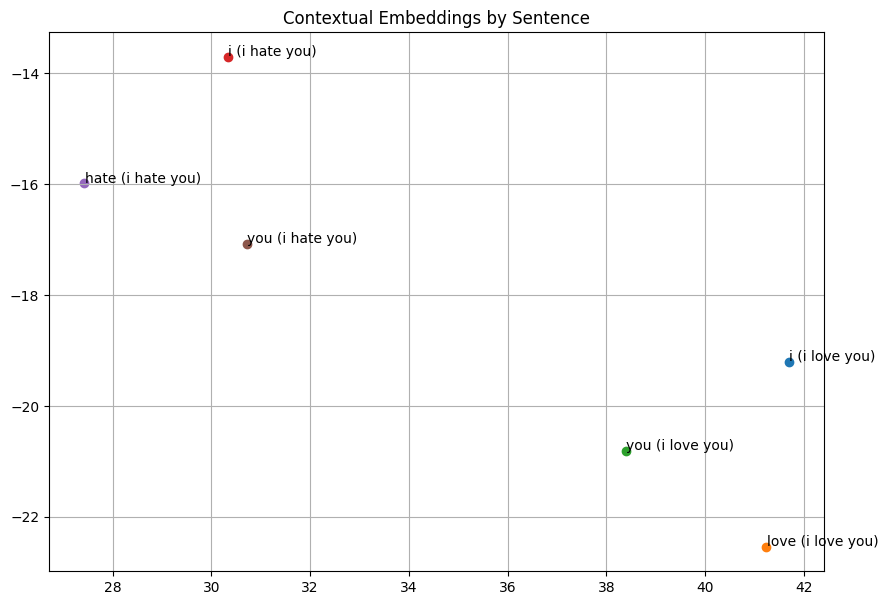

In [26]:
sentences = ["i love you", "i hate you"]
visualize_contextual_embeddings(model, dataset.token2idx, sentences)